# 1 - Quick start with Hookean dumbbells


In [1]:
import numpy as np
from browniandynamics.simulate import simulate_batch
from browniandynamics.molecules.Hookean_dumbbell import HookeanDumbbell
np.random.seed(2022)

## Parameters definition

In [2]:
n_ensemble = 1000   # Number of molecules to simulate
n_rec = 1000        # Number of time steps to record
dt = .001           # Time step value (dimensionless)
n_proc = 16         # Number of processor cores to use
                    

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution with variance ⅓ in each coordinate so that the average norm is 1. To do this with call `from_normal_distribution` constructor.

In [3]:
# Starting vectors
molecules = [HookeanDumbbell.from_normal_distribution()
             for i in range(n_ensemble)]

## Initial relaxation
Molecular dynamics simulations are usually preceeded by a relaxation/thermalisation step, which in our case is just a simulation with no velocity gradient. Although we know that for Hookean dumbbell the relaxed distribution is the one we just used to create new molecules, we still do it as an example of a first call to the `simulate_batch` function.

In [4]:
gradU = np.zeros((3, 3))
A, S, molecules_out = simulate_batch(molecules, gradU, n_rec, dt, n_proc)

Physical time to compute: 1.0
Calculation started on 16 cores.


100%|██████████| 1000/1000 [00:02<00:00, 341.67it/s]


We can investigate the dumbbell distribution in a number of ways. Let's look at time series and histograms.

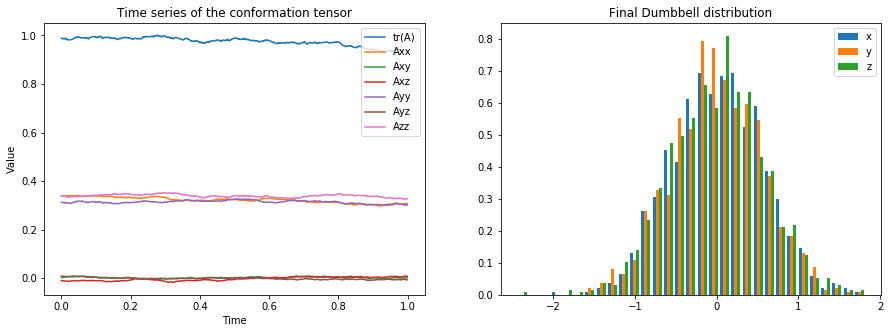

In [5]:
t = np.arange(n_rec)*dt
trA = np.trace(A, axis1=1, axis2=2)
Qs = np.array([molecule.Q for molecule in molecules_out])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([Qs[:,0], Qs[:,1], Qs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final Dumbbell distribution')
plt.show()

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We could simulate this scenario with constant velocity gradients and stitch the results together, but we can also use the interpolator `scipy.interpolate.interp1d` with the property `kind=previous`. This is more flexible and we will use linear interpolation in other examples.

In [6]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          1] # Relaxation will start from t = 1
gradU_base = [np.diag([1., -0.5, -0.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [7]:
n_rec = 2000
A, S, molecules_out = simulate_batch(molecules_out, gradU, n_rec, dt, n_proc)

Physical time to compute: 2.0
Calculation started on 16 cores.


100%|██████████| 1000/1000 [00:15<00:00, 62.57it/s]


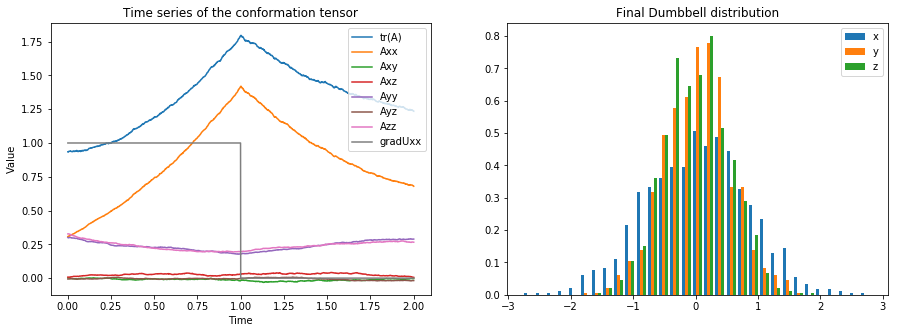

In [8]:
t = np.arange(1,n_rec+1)*dt
trA = np.trace(A, axis1=1, axis2=2)
Qs = np.array([molecule.Q for molecule in molecules_out])
gradUeval = gradU(t)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].plot(t, gradUeval[:,0,0], label='gradUxx')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([Qs[:,0], Qs[:,1], Qs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final Dumbbell distribution')
plt.show()

## Save result to a file
Here we save the result as *numpy arrays* compressed in a single file, as we expect further analysis with Python. Use other tools to save as text files.

In [9]:
params = {'model' : molecules[0].__class__.__name__,
          'model_attributes' : molecules[0].__dict__,
          'n_ensemble' : n_ensemble,
          'n_rec' : n_rec,
          'dt' : dt,
          'n_proc' : n_proc
          }
np.savez_compressed(output_file, A=A, S=S, t=t, gradU=gradUeval, params=params)